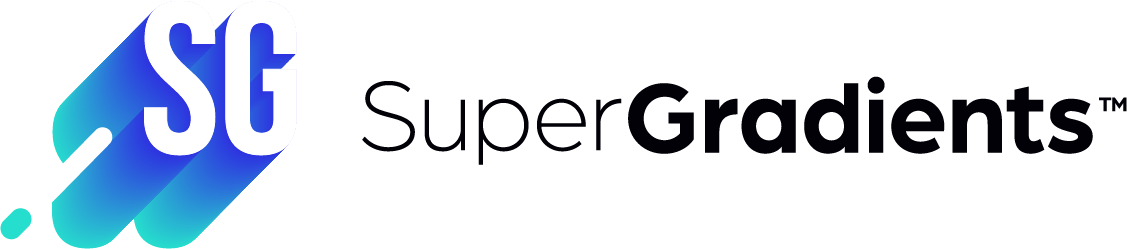

# SuperGradients Transfer Learning Semantic Segmentation

In the following tutorial, we will demonstrate how to use one of SuperGradients pre-trained models and a custom dataset to improve the model's accuracy using transfer learning for semantic segmentation.

Transfer Learning from a pre-trained checkpoint on your own dataset could prove to be very effective instead of deploying the pre-trained model directly on your data or training a model from scratch. For more information on Transfer Learning, please visit: https://cs231n.github.io/transfer-learning/

In the following example, transfer learning will be used from a Cityscapes PPLiteSeg model to a subset of the Supervisely person segmentation dataset .

For more details about the FILTERED dataset we wil use see: https://github.com/PaddlePaddle/PaddleSeg/tree/release/2.3/contrib/PP-HumanSeg

An example real-world use-case of the afformentioned scenario could be background removal in real time for video confrences.[link text](https://)

The notebook is divided into 7 sections:
1. Experiment setup
2. Dataset definition
3. Architecture definition
4. Training setup
5. Training and Evaluation
6. Predict
7. Convert to ONNX\TensorRT

#Install SG

The cell below will install **super_gradients** which will automatically get all its dependencies.

In [1]:
! pip install -qq super-gradients==3.6.0

# 1. Experiment setup
We will initialize our **trainer** which will be in charge of everything, like training, evaluation, saving checkpoints, plotting etc.

The **experiment name** argument is important as every checkpoints, logs and tensorboards to be saved in a directory with the same name. This directory will be created as a sub-directory of **ckpt_root_dir** as follow:

```
ckpt_root_dir
|─── experiment_name_1
│       ckpt_best.pth                     # Model checkpoint on best epoch
│       ckpt_latest.pth                   # Model checkpoint on last epoch
│       average_model.pth                 # Model checkpoint averaged over epochs
│       events.out.tfevents.1659878383... # Tensorflow artifacts of a specific run
│       log_Aug07_11_52_48.txt            # Trainer logs of a specific run
└─── experiment_name_2
        ...
```
In this notebook multi-gpu training is set as `OFF`, for Distributed training multi_gpu can be set as
 `MultiGPUMode.DISTRIBUTED_DATA_PARALLEL` or `MultiGPUMode.DATA_PARALLEL`.

Let's define **ckpt_root_dir** inside the Colab, later we can use it to start TensorBoard and monitor the run.

In [2]:
from super_gradients import Trainer

CHECKPOINT_DIR = './notebook_ckpts/'
trainer = Trainer(experiment_name="segmentation_transfer_learning", ckpt_root_dir=CHECKPOINT_DIR)

# 2. Dataset definition



For the sake of this presentation, we'll use **Supervisely** semantic segmentation dataset.

SG trainer is fully compatible with PyTorch data loaders, so you can definitely use your own data for the experiment below if you prefer.

## 2.1 Download data


Feel free to change the download path by editing SUPERVISELY_DATASET_DOWNLOAD_PATH

In [3]:
import os

SUPERVISELY_DATASET_DOWNLOAD_PATH=os.path.join(os.getcwd(),"data")

supervisely_dataset_dir_path = os.path.join(SUPERVISELY_DATASET_DOWNLOAD_PATH, 'supervisely-persons')

In [4]:
if os.path.isdir(supervisely_dataset_dir_path):
    print('supervisely dataset already downloaded...')
else:
    print('Downloading and extracting supervisely dataset to: ' + SUPERVISELY_DATASET_DOWNLOAD_PATH)
    ! mkdir $SUPERVISELY_DATASET_DOWNLOAD_PATH
    %cd $SUPERVISELY_DATASET_DOWNLOAD_PATH
    ! wget https://deci-pretrained-models.s3.amazonaws.com/supervisely-persons.zip
    ! unzip --qq supervisely-persons.zip

## 2.2 Create data loaders


The dataloaders are initiated with the default parameters defined in the [yaml](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/dataset_params/supervisely_persons_dataset_params.yaml)
file. Parameters as batch_size, transforms, root_dir and others can be overridden by passing as `dataset_params` and
`dataloader_params`, as implemented bellow.

In [5]:
from super_gradients.training import dataloaders

root_dir = supervisely_dataset_dir_path
batch_size = 8

train_loader = dataloaders.supervisely_persons_train(
    dataset_params={"root_dir": root_dir},
    dataloader_params={"batch_size": batch_size, "num_workers": 2}
)
valid_loader = dataloaders.supervisely_persons_val(
    dataset_params={"root_dir": root_dir},
    dataloader_params={"batch_size": batch_size, "num_workers": 2}
)

As you can see, we didn't have to pass many parameters into the dataloaders construction. That's because defaults are pre-defined for your convenience, and you might be curious to know what they are. Let's print them and see which resolution and transformations are defined.

In [6]:
print('Dataloader parameters:')
print(train_loader.dataloader_params)
print('Dataset parameters')
print(train_loader.dataset.dataset_params)

We can take a look at some images from the dataset.

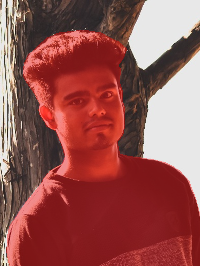

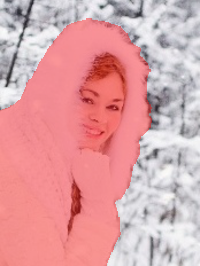

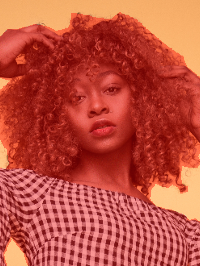

In [7]:
from PIL import Image
from torchvision.utils import draw_segmentation_masks
from torchvision.transforms import ToTensor, Resize, ToPILImage
import numpy as np
import torch

def plot_seg_data(img_path: str, target_path: str):
  image = (ToTensor()(Image.open(img_path).convert('RGB')) * 255).type(torch.uint8)
  target = torch.from_numpy(np.array(Image.open(target_path))).bool()
  image = draw_segmentation_masks(image, target, colors="red", alpha=0.4)
  image = Resize(size=200)(image)
  display(ToPILImage()(image))

for i in range(4, 7):
  img_path, target_path = train_loader.dataset.samples_targets_tuples_list[i]
  plot_seg_data(img_path, target_path)

# 3. Architecture definition



SG includes implementations of many different architectures for semantic segmentation tasks that can be found [here](https://github.com/Deci-AI/super-gradients#implemented-model-architectures).

Create a PPLiteSeg nn.Module, with 1 class segmentation head classifier. For simplicity `use_aux_head` is set as `False`
and extra Auxiliary heads aren't used for training.

Other segmentation modules can be used for this task such as, DDRNet, STDC and RegSeg.


In [8]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

model = models.get(model_name=Models.PP_LITE_T_SEG75,
                   arch_params={"use_aux_heads": False},
                   num_classes=1,
                   pretrained_weights="cityscapes")

# 4. Training setup





Here we define the training recipe. The full parameters can be found here  [training parameters supported](https://deci-ai.github.io/super-gradients/user_guide.html#training-parameters).

We will be using an average of BCE and Dice loss for segmentation, with different learning rates for the replaced segmentation head layer, and the rest of the network- this is controlled by the `multiply_head_lr` parameter which is the multiplication factor of the learning rate for the newly replaced layer.

As our `metric_to_watch`, we will be monitoring the `target_IOU` which is one of the components of `BinaryIOU` torchmetrics object (the other components are `mean_IOU` which is the mean of the background and target IOUs, and `background_IOU`).

In [9]:
from super_gradients.training.metrics.segmentation_metrics import BinaryIOU
from super_gradients.training.utils.callbacks import BinarySegmentationVisualizationCallback, Phase

train_params = {"max_epochs": 1,
                "lr_mode": "cosine",
                "initial_lr": 0.005,
                "lr_warmup_epochs": 5,
                "multiply_head_lr": 10,
                "optimizer": "SGD",
                "loss": "BCEDiceLoss",
                "ema": True,
                "ema_params":
                {
                "decay": 0.9999,
                "decay_type": "exp",
                "beta": 15,
                },
                "zero_weight_decay_on_bias_and_bn": True,
                "average_best_models": True,
                "metric_to_watch": "target_IOU",
                "greater_metric_to_watch_is_better": True,
                "train_metrics_list": [BinaryIOU()],
                "valid_metrics_list": [BinaryIOU()],
                "loss_logging_items_names": ["loss"],
                "phase_callbacks": [BinarySegmentationVisualizationCallback(phase=Phase.VALIDATION_BATCH_END,
                                                                            freq=1,
                                                                            last_img_idx_in_batch=4)],
                }

# 5. Training and evaluation


The logs and the checkpoint for the latest epoch will be kept in your experiment folder.

To start training we'll call train(...) and provide it with the objects we construted above: the model, the training parameters and the data loaders.

**Note:** While training, don't forget to refresh the tensorboard with the arrow on the top right.

In [10]:
trainer.train(model=model, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader)

Validating epoch 1: 100%|██████████| 65/65 [00:28<00:00, 10.22it/s]

In [11]:
print("Best Checkpoint mIoU is: "+ str(trainer.best_metric))

Now you can download your trained weights from this directory

In [12]:
print(trainer.checkpoints_dir_path)

# 6. Predict


When the training is complete you can use the trained model to get predictions on the validation set, your data or some other image. Let's load some image and
run a model inference to create a binary segmentation mask.

Validating epoch 1: 100%|██████████| 65/65 [00:30<00:00,  2.16it/s]


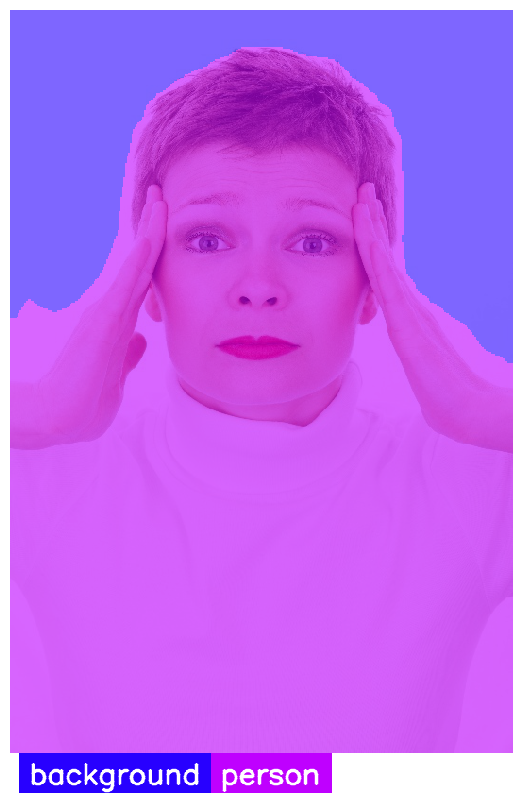

In [13]:
# Initiate a model with the best checkpoint.
model = models.get(model_name=Models.PP_LITE_T_SEG75,
                   arch_params={"use_aux_heads": False},
                   num_classes=1,
                   checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth")).cuda().eval()

demo_img_path = os.path.join(root_dir, "images", "ache-adult-depression-expression-41253.png")
model.predict(demo_img_path).show()

# 7. Convert to ONNX/TensorRT

Let's compile our model to ONNX.

In [18]:
from onnxsim import simplify
import onnx

onnx_path = os.path.join(os.getcwd(), "model.onnx")

input_size = [1, 3, 480, 320]
model.prep_model_for_conversion(input_size=input_size)

torch.onnx.export(model,
                  torch.randn(*input_size).cuda(),
                  onnx_path)

# onnx simplifier
model_sim, check = simplify(onnx_path)
assert check, "Simplified ONNX model could not be validated"
onnx.save_model(model_sim, onnx_path)

print("ONNX successfully created at: ", onnx_path)
